In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Dropout
from keras.layers import Dense
from keras.regularizers import l2, l1

#Regression for predicted yardage Panthers
def build():
    network = keras.models.Sequential()
    network.add(Dense(12, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l1(1.e-3)))
    network.add(Dense(5, activation='relu', kernel_regularizer=l2(1.e-3)))
    network.add(Dense(1, activation = 'linear'))
    network.compile(loss='mse', optimizer="adam" ,metrics=['mean_absolute_error'])
    return network

#Data preparation for regression Panthers
def data_prep(data):
    data = pd.get_dummies(data)
    y = data['GN/LS']
    x = data.drop(columns = ['GN/LS'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    cols = ['DIST', 'YARD LN']
    for x in cols:
        mean = x_train[x].mean(axis=0)
        x_train[x] -= mean
        std = x_train[x].std(axis=0)
        x_train[x] /= std
        x_test[x] -= mean
        x_test[x] /= std
        
    y_train /= 10
    y_test /= 10
    return x_train, x_test, y_train, y_test

#Regression k-cross-validation
def cross_valid_reg(k, num_epochs, x_train, y_train, x_test, y_test):
    samples = len(x_train) // k
    val_history = []
    train_history = []
    for i in range(k):
        data = x_train[i * samples: (i + 1) * samples]
        targets = y_train[i * samples: (i + 1) * samples]
        partial_train_data = np.concatenate([x_train[:i * samples], x_train[(i + 1) * samples:]],axis=0)
        partial_train_targets = np.concatenate([y_train[:i * samples],y_train[(i + 1) * samples:]],axis=0)
        model = build()
        if i == 0:
            print('Input size: ', x_train.shape)
            print(model.summary())
        hist = model.fit(partial_train_data, partial_train_targets, validation_data=(data, targets),
                         epochs=num_epochs, batch_size=100, verbose=0)
        loss_history1 = hist.history['val_loss']
        loss_history2 = hist.history['loss']
        val_history.append(loss_history1)
        train_history.append(loss_history2)
        
    val_history = [np.mean([x[i] for x in val_history]) for i in range(num_epochs)]
    train_history = [np.mean([x[i] for x in train_history]) for i in range(num_epochs)]
    plt.figure(figsize=(12, 8))
    plt.rcParams.update({'font.size': 24})
    plt.plot(range(1, len(val_history) + 1), val_history)
    plt.plot(range(1, len(train_history) + 1), train_history)
    plt.xlabel('Epochs')
    plt.ylabel('loss_function')
    plt.legend(['Validation', 'Training'])
    plt.savefig('YardsPanthers.png')
    plt.show()
    _,mae = model.evaluate(x_test, y_test)
    print('Mean Absolute Error of the network is ', mae)
    
    

Input size:  (150, 21)
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_297 (Dense)            (None, 12)                264       
_________________________________________________________________
dense_298 (Dense)            (None, 5)                 65        
_________________________________________________________________
dense_299 (Dense)            (None, 1)                 6         
Total params: 335
Trainable params: 335
Non-trainable params: 0
_________________________________________________________________
None


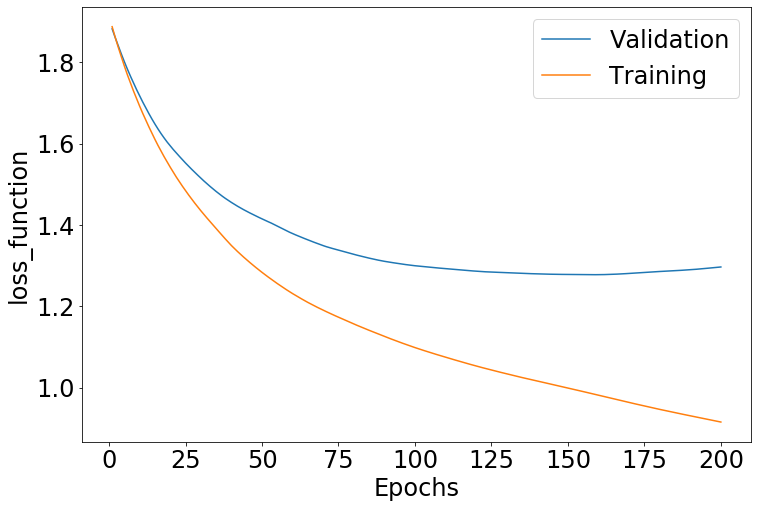

2/2 [==============================] - 0s 999us/step - loss: 1.5649 - mean_absolute_error: 0.7814
Mean Absolute Error of the network is  0.7814447283744812
Guessing that every play results in set's average gain generates mean absolute error:  0.5973333333333332


In [42]:
#Panthers Regression for predicted yardage
data = pd.read_csv("data/PanthersReg.csv")
x_train, x_test, y_train, y_test = data_prep(data)

#Benchmark
meany = y_train.median()
error = pd.Series(y_train-meany)
error = abs(error)
benchmark = error.mean()

cross_valid_reg(3, 200, x_train, y_train, x_test, y_test)
print('Guessing that every play results in set\'s average gain generates mean absolute error: ', benchmark)



In [3]:
data = pd.read_csv("data/PanthersReg.csv")
data.describe()

,DIST,YARD LN,GN/LS
count,188.000000,188.000000,188.000000
mean,8.547872,39.164894,6.207447
std,3.587388,26.121261,11.102563
min,1.000000,1.000000,-10.000000
25%,7.000000,14.750000,1.000000
50%,10.000000,38.000000,3.500000
75%,10.000000,59.000000,8.000000
max,29.000000,93.000000,71.000000
